In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from pgmpy.models import FactorGraph
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import BeliefPropagation
import numpy as np
import networkx as nx
import pandas as pd
from collections import Counter
from pgmpy.estimators import MirrorDescentEstimator
from pgmpy.factors import FactorDict

In [3]:
def print_teams_games(games: pd.DataFrame, team: str) -> None:
    print(
        games.loc[
            (games.homeTeamAbbr == team) | (games.visitorTeamAbbr == team)
        ].to_numpy()
    )

In [4]:
games = pd.read_csv("games.csv")
# Find all the teams playing in the games.
TEAMS = sorted(set(games.homeTeamAbbr).union(set(games.visitorTeamAbbr)))
WIN_VALUE = 1.0
TIE_VALUE = 0.5
NULL_VALUE = 1e-6
state_names = ["win", "loss"]

In [5]:
Counter(
    [
        row[1].homeTeamAbbr
        if row[1].homeFinalScore > row[1].visitorFinalScore
        else row[1].visitorTeamAbbr
        for row in games.iterrows()
    ]
)

Counter({'DET': 14,
         'BAL': 14,
         'SF': 13,
         'KC': 13,
         'DAL': 12,
         'BUF': 12,
         'CLE': 11,
         'MIA': 11,
         'PHI': 11,
         'HOU': 11,
         'TB': 10,
         'LAR': 10,
         'GB': 10,
         'PIT': 10,
         'NO': 9,
         'JAC': 9,
         'IND': 9,
         'SEA': 9,
         'CIN': 9,
         'LV': 8,
         'DEN': 8,
         'ATL': 7,
         'NYJ': 7,
         'MIN': 7,
         'CHI': 7,
         'TEN': 6,
         'NYG': 6,
         'LAC': 5,
         'WAS': 4,
         'NE': 4,
         'ARI': 4,
         'CAR': 2})

# Attempt 1

In [6]:
def win_loss_graph(G, home_team, away_team, home_score, visitor_score):
    tie = False
    if home_score == visitor_score:
        tie = True

    # Determine who won the game. Tie goes to the winner.
    winning_team, losing_team = (
        (home_team, away_team)
        if home_score >= visitor_score
        else (away_team, home_team)
    )

    # Find the DiscreteFactor representing this game.
    winning_team_neighbors = list(G.adj[winning_team])
    matching_factors = [i for i in winning_team_neighbors if losing_team in i.scope()]

    # Create a new DiscreteFactor representing a game.
    if len(matching_factors) == 0:
        phi = DiscreteFactor(
            variables=[winning_team, losing_team],
            cardinality=[2, 2],
            values=np.array([NULL_VALUE, NULL_VALUE, WIN_VALUE, NULL_VALUE])
            if not tie
            else np.array([TIE_VALUE, NULL_VALUE, NULL_VALUE, TIE_VALUE]),
            state_names={winning_team: state_names, losing_team: state_names},
        )
        G.add_nodes_from([phi])
    # Update an existing game.
    elif len(matching_factors) == 1:
        phi = matching_factors[0]
        G.remove_factors(phi)
        if not tie:
            phi.set_value(
                value=phi.get_value(**{winning_team: "win", losing_team: "lose"})
                + WIN_VALUE,
                **{winning_team: "win", losing_team: "lose"}
            )
        else:
            # Losing tie
            phi.set_value(
                value=phi.get_value(**{winning_team: "lose", losing_team: "lose"})
                + TIE_VALUE,
                **{winning_team: "lose", losing_team: "lose"}
            )

            # Winning tie
            phi.set_value(
                value=phi.get_value(**{winning_team: "win", losing_team: "win"})
                + TIE_VALUE,
                **{winning_team: "win", losing_team: "win"}
            )
    else:
        raise ValueError()
    G.add_factors(phi)
    G.add_edges_from([(winning_team, phi), (losing_team, phi)])

In [7]:
def score_delta_graph(G, home_team, away_team, home_score, visitor_score):
    tie = False
    if home_score == visitor_score:
        tie = True

    # Determine who won the game. Tie goes to the winner.
    winning_team, losing_team = (
        (home_team, away_team)
        if home_score >= visitor_score
        else (away_team, home_team)
    )

    score_diff = abs(home_score - visitor_score)

    # Find the DiscreteFactor representing this game.
    winning_team_neighbors = list(G.adj[winning_team])
    matching_factors = [i for i in winning_team_neighbors if losing_team in i.scope()]

    # Create a new DiscreteFactor representing a game.
    if len(matching_factors) == 0:
        phi = DiscreteFactor(
            variables=[winning_team, losing_team],
            cardinality=[2, 2],
            values=np.array([NULL_VALUE, NULL_VALUE, score_diff, NULL_VALUE])
            if not tie
            else np.array([NULL_VALUE, home_score, home_score, NULL_VALUE]),
            state_names={winning_team: state_names, losing_team: state_names},
        )
        G.add_nodes_from([phi])
    # Update an existing game.
    elif len(matching_factors) == 1:
        phi = matching_factors[0]
        G.remove_factors(phi)
        if not tie:
            phi.set_value(
                value=phi.get_value(**{winning_team: "win", losing_team: "lose"})
                + score_diff,
                **{winning_team: "win", losing_team: "lose"}
            )
        else:
            # Losing tie
            phi.set_value(
                value=phi.get_value(**{winning_team: "lose", losing_team: "lose"})
                + home_score,
                **{winning_team: "lose", losing_team: "lose"}
            )
            # Winning tie
            phi.set_value(
                value=phi.get_value(**{winning_team: "win", losing_team: "win"})
                + home_score,
                **{winning_team: "win", losing_team: "win"}
            )
    else:
        raise ValueError()
    G.add_factors(phi)
    G.add_edges_from([(winning_team, phi), (losing_team, phi)])

In [8]:
def score_graph(G, home_team, away_team, home_score, visitor_score):
    # Find the DiscreteFactor representing this game.
    home_team_neighbors = list(G.adj[home_team])
    matching_factors = [i for i in home_team_neighbors if away_team in i.scope()]

    # Create a new DiscreteFactor representing a game.
    if len(matching_factors) == 0:
        phi = DiscreteFactor(
            variables=[home_team, away_team],
            cardinality=[2, 2],
            values=np.array([NULL_VALUE, visitor_score, home_score, NULL_VALUE]),
            state_names={home_team: state_names, away_team: state_names},
        )
        G.add_nodes_from([phi])
    # Update an existing game.
    elif len(matching_factors) == 1:
        phi = matching_factors[0]
        G.remove_factors(phi)
        phi.set_value(
            value=phi.get_value(**{home_team: "win", away_team: "lose"}) + home_score,
            **{home_team: "win", away_team: "lose"}
        )
        phi.set_value(
            value=phi.get_value(**{home_team: "lose", away_team: "win"})
            + visitor_score,
            **{home_team: "lose", away_team: "win"}
        )
    else:
        raise ValueError()
    G.add_factors(phi)
    G.add_edges_from([(home_team, phi), (away_team, phi)])

# Graph Construction

In [9]:
G = FactorGraph()
G.add_nodes_from(nodes=TEAMS)
state_names = ["lose", "win"]
for i, row in games.iterrows():
    # Unpack data from this row.
    home_team = row.homeTeamAbbr
    away_team = row.visitorTeamAbbr
    home_score = row.homeFinalScore
    visitor_score = row.visitorFinalScore

    # win_loss_graph(G, home_team, away_team, home_score, visitor_score)
    # score_delta_graph(G, home_team, away_team, home_score, visitor_score)
    score_graph(G, home_team, away_team, home_score, visitor_score)

In [10]:
G.check_model()

True

In [11]:
print(list(G.adj["SEA"])[0])

+-----------+-----------+----------------+
| DET       | SEA       |   phi(DET,SEA) |
+===========+===========+================+
| DET(lose) | SEA(lose) |         0.0000 |
+-----------+-----------+----------------+
| DET(lose) | SEA(win)  |        37.0000 |
+-----------+-----------+----------------+
| DET(win)  | SEA(lose) |        31.0000 |
+-----------+-----------+----------------+
| DET(win)  | SEA(win)  |         0.0000 |
+-----------+-----------+----------------+


In [12]:
print_teams_games(games, "DAL")

[['09/10/2023' 'Dallas Cowboys' 'DAL' 40 'New York Giants' 'NYG' 0]
 ['09/17/2023' 'New York Jets' 'NYJ' 10 'Dallas Cowboys' 'DAL' 30]
 ['09/24/2023' 'Dallas Cowboys' 'DAL' 16 'Arizona Cardinals' 'ARI' 28]
 ['10/01/2023' 'New England Patriots' 'NE' 3 'Dallas Cowboys' 'DAL' 38]
 ['10/08/2023' 'Dallas Cowboys' 'DAL' 10 'San Francisco 49ers' 'SF' 42]
 ['10/16/2023' 'Dallas Cowboys' 'DAL' 20 'Los Angeles Chargers' 'LAC' 17]
 ['10/29/2023' 'Los Angeles Rams' 'LAR' 20 'Dallas Cowboys' 'DAL' 43]
 ['11/05/2023' 'Dallas Cowboys' 'DAL' 23 'Philadelphia Eagles' 'PHI' 28]
 ['11/12/2023' 'New York Giants' 'NYG' 17 'Dallas Cowboys' 'DAL' 49]
 ['11/19/2023' 'Dallas Cowboys' 'DAL' 33 'Carolina Panthers' 'CAR' 10]
 ['11/23/2023' 'Washington Commanders' 'WAS' 10 'Dallas Cowboys' 'DAL' 45]
 ['11/30/2023' 'Seattle Seahawks' 'SEA' 35 'Dallas Cowboys' 'DAL' 41]
 ['12/10/2023' 'Philadelphia Eagles' 'PHI' 13 'Dallas Cowboys' 'DAL' 33]
 ['12/17/2023' 'Dallas Cowboys' 'DAL' 10 'Buffalo Bills' 'BUF' 31]
 ['12/24

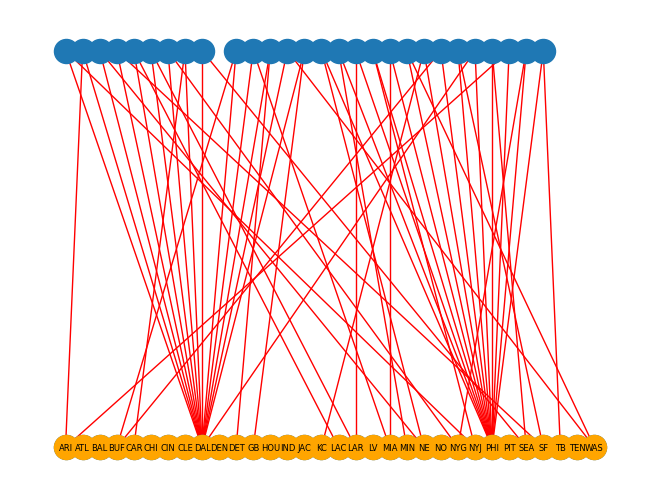

In [13]:
# Visualize two team's factors with NetworkX
factor_list = list(G.adj["DAL"]) + list(G.adj["PHI"])

top = {team: (i, 0) for i, team in enumerate(sorted(TEAMS))}
bottom = {factor: (i, 1) for i, factor in enumerate(factor_list)}

nx.draw(
    G.subgraph(TEAMS + factor_list),
    pos={**top, **bottom},
    edge_color="red",
)
nx.draw(
    G.subgraph(TEAMS),
    node_color="orange",
    pos=top,
    with_labels=True,
    font_size=6,
)

In [14]:
belief_propagation = BeliefPropagation(G)

In [19]:
query_factor = belief_propagation.query(
    variables=TEAMS, joint=False, show_progress=True
)

/Users/jakeetaylor/pgmpy/pgmpy/factors/discrete/DiscreteFactor.py:796: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi1.values


In [18]:
print(query_factor["DAL"])

+-----------+------------+
| DAL       |   phi(DAL) |
+===========+============+
| DAL(lose) |     0.0000 |
+-----------+------------+
| DAL(win)  |     1.0000 |
+-----------+------------+


In [16]:
print(query_factor)

{'DAL': <DiscreteFactor representing phi(DAL:2) at 0x2a40079d0>, 'PHI': <DiscreteFactor representing phi(PHI:2) at 0x2a4007970>}


In [92]:
print_teams_games(games, "DAL")

[['09/10/2023' 'Dallas Cowboys' 'DAL' 40 'New York Giants' 'NYG' 0]
 ['09/17/2023' 'New York Jets' 'NYJ' 10 'Dallas Cowboys' 'DAL' 30]
 ['09/24/2023' 'Dallas Cowboys' 'DAL' 16 'Arizona Cardinals' 'ARI' 28]
 ['10/01/2023' 'New England Patriots' 'NE' 3 'Dallas Cowboys' 'DAL' 38]
 ['10/08/2023' 'Dallas Cowboys' 'DAL' 10 'San Francisco 49ers' 'SF' 42]
 ['10/16/2023' 'Dallas Cowboys' 'DAL' 20 'Los Angeles Chargers' 'LAC' 17]
 ['10/29/2023' 'Los Angeles Rams' 'LAR' 20 'Dallas Cowboys' 'DAL' 43]
 ['11/05/2023' 'Dallas Cowboys' 'DAL' 23 'Philadelphia Eagles' 'PHI' 28]
 ['11/12/2023' 'New York Giants' 'NYG' 17 'Dallas Cowboys' 'DAL' 49]
 ['11/19/2023' 'Dallas Cowboys' 'DAL' 33 'Carolina Panthers' 'CAR' 10]
 ['11/23/2023' 'Washington Commanders' 'WAS' 10 'Dallas Cowboys' 'DAL' 45]
 ['11/30/2023' 'Seattle Seahawks' 'SEA' 35 'Dallas Cowboys' 'DAL' 41]
 ['12/10/2023' 'Philadelphia Eagles' 'PHI' 13 'Dallas Cowboys' 'DAL' 33]
 ['12/17/2023' 'Dallas Cowboys' 'DAL' 10 'Buffalo Bills' 'BUF' 31]
 ['12/24

# Attempt 2

In [6]:
games = pd.read_csv("games.csv")
games["homeWin"] = (games.homeFinalScore >= games.visitorFinalScore).map(
    lambda x: "win" if x else "loss"
)
TEAMS = sorted(set(games.homeTeamAbbr).union(set(games.visitorTeamAbbr)))
df = games[["homeTeamAbbr", "visitorTeamAbbr", "homeWin"]]
df.head()

,homeTeamAbbr,visitorTeamAbbr,homeWin
0,KC,DET,loss
1,MIN,TB,loss
2,NO,TEN,win
3,ATL,CAR,win
4,BAL,HOU,win


In [7]:
G = FactorGraph()
nodes = ["homeTeamAbbr", "visitorTeamAbbr", "homeWin"]
state_names = {
    "homeTeamAbbr": TEAMS,
    "visitorTeamAbbr": TEAMS,
    "homeWin": ["loss", "win"],
}
factors = [
    # One-way marginals.
    DiscreteFactor(
        variables=["homeTeamAbbr"],
        cardinality=[32],
        values=np.zeros(32),
        state_names=state_names,
    ),
    DiscreteFactor(
        variables=["visitorTeamAbbr"],
        cardinality=[32],
        values=np.zeros(32),
        state_names=state_names,
    ),
    DiscreteFactor(
        variables=["homeWin"],
        cardinality=[2],
        values=np.zeros(2),
        state_names=state_names,
    ),
    # Two-way marginals.
    DiscreteFactor(
        variables=["homeTeamAbbr", "homeWin"],
        cardinality=[32, 2],
        values=np.zeros((32, 2)),
        state_names=state_names,
    ),
    DiscreteFactor(
        variables=["visitorTeamAbbr", "homeWin"],
        cardinality=[32, 2],
        values=np.zeros((32, 2)),
        state_names=state_names,
    ),
    # Three-way marginal.
    DiscreteFactor(
        variables=["homeTeamAbbr", "visitorTeamAbbr", "homeWin"],
        cardinality=[32, 32, 2],
        values=np.zeros((32, 32, 2)),
        state_names=state_names,
    ),
]
G.add_nodes_from(nodes=nodes)
G.add_factors(*factors)
G.add_edges_from(
    [(node, factor) for node in nodes for factor in factors if node in factor.scope()]
)

In [8]:
G.check_model()

True

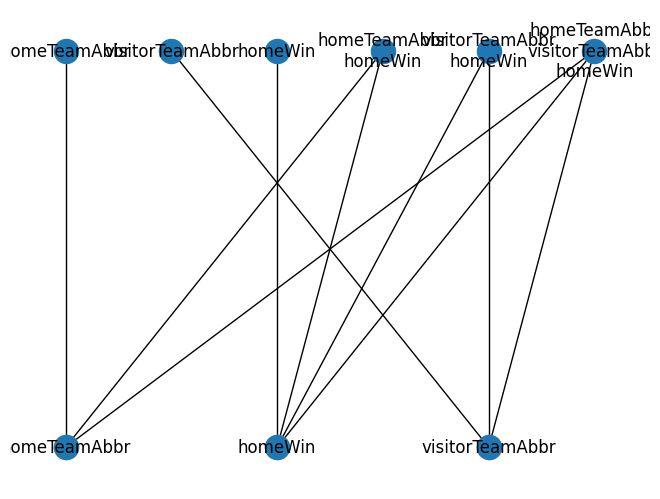

In [9]:
top = {team: (i * 2, 0) for i, team in enumerate(sorted(nodes))}
bottom = {factor: (i, 1) for i, factor in enumerate(factors)}
label_dict = {factor: "\n".join(factor.scope()) for factor in G.factors}
label_dict.update({node: node for node in nodes})
nx.draw(
    G.subgraph(nodes),
    node_color="orange",
    pos={**top},
)
nx.draw(
    G,
    pos={**top, **bottom},
    with_labels=True,
    labels=label_dict,
)

In [12]:
# Initialize model
estimator = MirrorDescentEstimator(model=G, data=games)
marginals = [tuple(i.scope()) for i in G.factors]
factor_dict = FactorDict.from_dataframe(df=games, marginals=marginals)

In [13]:
%%time
tree = estimator.estimate(
    marginals=marginals, metric="L2", iterations=30_000
)

  0%|          | 0/30000 [00:00<?, ?it/s]

CPU times: user 17.8 s, sys: 2.43 s, total: 20.2 s
Wall time: 20.6 s


In [14]:
print(factor_dict[("homeWin",)])

+---------------+----------------+
| homeWin       |   phi(homeWin) |
+===============+================+
| homeWin(loss) |       123.0000 |
+---------------+----------------+
| homeWin(win)  |       159.0000 |
+---------------+----------------+


In [15]:
print(tree.factors[0].marginalize(["homeTeamAbbr", "visitorTeamAbbr"], inplace=False))

+---------------+----------------+
| homeWin       |   phi(homeWin) |
+===============+================+
| homeWin(loss) |       123.0000 |
+---------------+----------------+
| homeWin(win)  |       159.0000 |
+---------------+----------------+


In [16]:
print(factor_dict[("visitorTeamAbbr", "homeWin")].values.flatten())

[2. 7. 2. 7. 7. 1. 4. 4. 0. 9. 2. 7. 3. 5. 3. 6. 4. 5. 3. 5. 6. 3. 5. 6.
 4. 5. 5. 3. 5. 3. 7. 2. 3. 5. 5. 5. 2. 6. 4. 5. 5. 4. 3. 5. 4. 5. 2. 7.
 3. 5. 5. 5. 5. 4. 4. 5. 7. 2. 5. 5. 1. 7. 3. 6.]


In [17]:
print(tree.factors[0].marginalize(["homeTeamAbbr"], inplace=False).values.flatten())

[2.0000000e+00 7.0000000e+00 2.0000000e+00 7.0000000e+00 7.0000000e+00
 1.0000000e+00 4.0000000e+00 4.0000000e+00 5.9924031e-11 9.0000000e+00
 2.0000000e+00 7.0000000e+00 3.0000000e+00 5.0000000e+00 3.0000000e+00
 6.0000000e+00 4.0000000e+00 5.0000000e+00 3.0000000e+00 5.0000000e+00
 6.0000000e+00 3.0000000e+00 5.0000000e+00 6.0000000e+00 4.0000000e+00
 5.0000000e+00 5.0000000e+00 3.0000000e+00 5.0000000e+00 3.0000000e+00
 7.0000000e+00 2.0000000e+00 3.0000000e+00 5.0000000e+00 5.0000000e+00
 5.0000000e+00 2.0000000e+00 6.0000000e+00 4.0000000e+00 5.0000000e+00
 5.0000000e+00 4.0000000e+00 3.0000000e+00 5.0000000e+00 4.0000000e+00
 5.0000000e+00 2.0000000e+00 7.0000000e+00 3.0000000e+00 5.0000000e+00
 5.0000000e+00 5.0000000e+00 5.0000000e+00 4.0000000e+00 4.0000000e+00
 5.0000000e+00 7.0000000e+00 2.0000000e+00 5.0000000e+00 5.0000000e+00
 1.0000000e+00 7.0000000e+00 3.0000000e+00 6.0000000e+00]


In [18]:
query_factor = BeliefPropagation(tree).query(
    variables=["homeWin"],
    evidence={"homeTeamAbbr": "DAL", "visitorTeamAbbr": "SF"},
    joint=True,
    show_progress=True,
)

In [19]:
print(query_factor)

+---------------+----------------+
| homeWin       |   phi(homeWin) |
+===============+================+
| homeWin(loss) |         0.4524 |
+---------------+----------------+
| homeWin(win)  |         0.5476 |
+---------------+----------------+


# Test log operations

In [819]:
G = FactorGraph()
G.add_nodes_from(["a", "b", "c"])
phi1 = DiscreteFactor(["a", "b"], [2, 2], np.array([1e-2, 1e-2, 1, 1e-2]))
phi2 = DiscreteFactor(["b", "c"], [2, 2], np.array([1e-2, 1e-2, 1, 1e-2]))
G.add_factors(phi1, phi2)
G.add_nodes_from([phi1, phi2])
G.add_edges_from([("a", phi1), ("b", phi1), ("b", phi2), ("c", phi2)])
G.get_factors()

[<DiscreteFactor representing phi(a:2, b:2) at 0x2b19dfd60>,
 <DiscreteFactor representing phi(b:2, c:2) at 0x2b19dcfa0>]

In [820]:
print(phi1)

+------+------+------------+
| a    | b    |   phi(a,b) |
+======+======+============+
| a(0) | b(0) |     0.0100 |
+------+------+------------+
| a(0) | b(1) |     0.0100 |
+------+------+------------+
| a(1) | b(0) |     1.0000 |
+------+------+------------+
| a(1) | b(1) |     0.0100 |
+------+------+------------+


In [821]:
print(phi2)

+------+------+------------+
| b    | c    |   phi(b,c) |
+======+======+============+
| b(0) | c(0) |     0.0100 |
+------+------+------------+
| b(0) | c(1) |     0.0100 |
+------+------+------------+
| b(1) | c(0) |     1.0000 |
+------+------+------------+
| b(1) | c(1) |     0.0100 |
+------+------+------------+


In [822]:
G.get_partition_function()

0.040400000000000005

In [823]:
np.exp(G.get_log_partition_function())

0.04040000000000002